In [12]:
import pandas as pd
from tqdm import tqdm

# 1. Assesment Library Composition for Every Predictor  

## Training Sets

In [13]:
train_ST = "/home/sander/apps/slim/ptm_predictions/Phospho-Sites_KnowledgeBase/train_ST.fasta"
train_Y = "/home/sander/apps/slim/ptm_predictions/Phospho-Sites_KnowledgeBase/train_Y.fasta"

## Prediction of All Candidate Sites

In [14]:
ST_sites = pd.read_csv("/home/sander/apps/slim/ptm_predictions/ST_Phospho_Human_Peptides_2,7,30_Preds.csv") 
Y_sites = pd.read_csv("/home/sander/apps/slim/ptm_predictions/Y_Phospho_Human_Peptides_2,7,30_Preds.csv")

# Concatenate the two DataFrames vertically
combined_df = pd.concat([ST_sites, Y_sites], axis=0, ignore_index=True)
# Sort the combined DataFrame by protein ID and position
combined_df = combined_df.sort_values(['prot_id', 'position'])
# Reset the index after sorting
combined_df = combined_df.reset_index(drop=True)

## Combining the 2 Datasets

In [15]:
def get_sites(filenames):
    """
    Input: 
        >Q9BSJ6
        MASRWQNMGT@S#VRRRS#LQHQEQLEDS@KELQPVVS@HQET@S@VGALGSLCRQFQRRLPLRAVNLNLRAGPSWKRLET#PEPGQQGLQAAARSAKS#ALGAVS@QRIQES@C...
        >...

    Processing: 
        Target sites are annotated with tailing symbols: @ means no modification has been found, # means modification on this residue has been found.
        The challenge here is to correctly determine the position of the amino acid without counting the annotations: # and @. 
        Only put a site in the dataframe when it has a positive annotation.  
        
    Output: 
        pandas dataframe:
        prot_id, position
        Q9BSJ6, 11
        Q9BSJ6, 16
        ...
    """
    sites = []
    current_protein = None

    # Iterate over each file
    for filename in filenames:
        current_protein = None
            
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                
                # Handle protein ID lines (starting with >)
                if line.startswith('>'):
                    current_protein = line[1:]  # Remove the '>' character
                    continue
                    
                # Handle sequence lines
                if current_protein and line:
                    # Initialize position counter (not counting annotations)
                    true_position = 0
                    
                    # Iterate through the sequence
                    for i, char in enumerate(line):
                        if char not in ['@', '#']:
                            # Increment position for actual amino acids
                            true_position += 1
                        elif char == '#':
                            # Add to our sites list
                            sites.append({
                                'prot_id': current_protein,
                                'position': true_position
                            })
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(sites)
    # Sort by protein ID and position
    df = df.sort_values(['prot_id', 'position']).reset_index(drop=True)
    
    return df

In [16]:
train_sites = get_sites([train_Y, train_ST])

In [17]:
train_sites.head()

,prot_id,position
0,A0A087WUL8,364
1,A0A096LP49,519
2,A0AVK6,52
3,A0AVK6,58
4,A0AVK6,71


# Novel vs. Known

In [18]:
def read_proteome(canonical_proteome):
    """
    Reads the proteome sequences from the FASTA file, filters X and U aa from proteome

    Parameters:
    canonical_proteome : str
        Path to the FASTA file containing the proteome sequences

    Returns:
    dict
        A dictionary where keys are protein IDs and values are sequences
        {prot1: 'PEPTIDERRRPEPTIDE...', ...}
    """
    sequences = {}  # {prot_id: sequence}
    with open(canonical_proteome, 'r') as f:
        prot_id = None
        seq_lines = []
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if prot_id:
                    sequence = ''.join(seq_lines)
                    if 'U' not in sequence and 'X' not in sequence:
                        sequences[prot_id] = sequence
                    seq_lines = []
                prot_id = line[1:].split()[0]
            else:
                seq_lines.append(line)
        if prot_id:
            sequence = ''.join(seq_lines)
            if 'U' not in sequence and 'X' not in sequence:
                sequences[prot_id] = sequence
    return sequences

canonical_proteome = '/home/sander/apps/slim/general_data/UP000005640_9606_prot_id.fasta'
proteome = read_proteome(canonical_proteome)

def digest_protein(sequence, missed_cleavages=0, min_length=0, max_length=None):
    """
    Performs trypsin digestion on a single protein sequence.

    Args:
        sequence (str): Protein sequence
        missed_cleavages (int): Number of allowed missed cleavages
        min_length (int): Minimum peptide length
        max_length (int): Maximum peptide length (None for no limit)

    Returns:
        list: List of tuples (peptide, start_pos) where start_pos is 0-based

    Example:
        Input: "PEPTIDERPRRPEPTIDE"
        Output: [('PEPTIDER', 0), ('PEPTIDERR', 0), ..., ('RPEPTIDE', 9)]
    """
    cleavage_sites = []
    for i in range(len(sequence) - 1):
        if sequence[i] in ('K', 'R'): # and sequence[i+1] != 'P':
            cleavage_sites.append(i+1)
    cleavage_sites = [0] + cleavage_sites + [len(sequence)]
    
    peptides = []
    for start_idx in range(len(cleavage_sites)-1):
        for end_idx in range(start_idx+1, min(len(cleavage_sites), start_idx+missed_cleavages+2)):
            pep_start = cleavage_sites[start_idx]
            pep_end = cleavage_sites[end_idx]
            peptide = sequence[pep_start:pep_end]
            if min_length <= len(peptide) <= (max_length if max_length else len(peptide)):
                # Validate that the peptide actually starts at pep_start
                assert sequence[pep_start:pep_start+len(peptide)] == peptide
                peptides.append((peptide, pep_start))
    return peptides

def calculate_miscleavages(peptide_seq, protein_seq, start_pos):
    """
    Calculates the number of missed cleavages in a single peptide.

    Args:
        peptide_seq (str): Peptide sequence
        protein_seq (str): Full protein sequence
        start_pos (int): Start position of peptide in protein (0-based)

    Returns:
        int: Number of missed cleavages

    Example:
        Input: ('PEPTIDERPR', 'PEPTIDERPRRPEPTIDE', 0)
        Output: 1
    """
    # Validate that the peptide actually occurs at start_pos
    assert protein_seq[start_pos:start_pos+len(peptide_seq)] == peptide_seq, \
           f"Peptide {peptide_seq} not found at position {start_pos} in protein"
    
    miscleavages = 0
    for i in range(len(peptide_seq)-1):  # Changed range to avoid going past peptide end
        abs_pos = start_pos + i  # Removed the -1 offset
        if protein_seq[abs_pos] in ('K', 'R'):
            miscleavages += 1
    return miscleavages

def trypsin_digest(sequences, missed_cleavages, min_length, max_length):
    """
    Performs trypsin digestion on all protein sequences.
    
    Args:
        sequences (dict): Dictionary of protein sequences {prot_id: sequence}
        missed_cleavages (int): Number of allowed missed cleavages
        min_length (int): Minimum peptide length
        max_length (int): Maximum peptide length

    Returns:
        list: List of dictionaries containing peptide information
        
    Example:
        Input: {'prot1': 'PEPTIDERRRPEPTIDE...', ...}
        Output: [{'prot_id': 'prot1', 'sequence': 'PEPTIDERPR', 'miscleavages': 1, 
                 'peptide_length': 10, 'start_pos': 0}, ...]
    """
    digested_peptides = []
    for prot_id, seq in sequences.items():
        peptides = digest_protein(seq, missed_cleavages, min_length, max_length)
        for peptide, start_pos in peptides:
            # Validate peptide position
            assert seq[start_pos:start_pos+len(peptide)] == peptide, \
                   f"Position mismatch for peptide {peptide} in protein {prot_id}"
            
            miscleavages = calculate_miscleavages(peptide, seq, start_pos)
            digested_peptides.append({
                'prot_id': prot_id,
                'sequence': peptide,
                'miscleavages': miscleavages,
                'peptide_length': len(peptide),
                'start_pos': start_pos
            })
    return digested_peptides

peptides = trypsin_digest(sequences = proteome, missed_cleavages = 2, min_length = 7, max_length = 30)

In [19]:
def add_reference_indicator(df, reference_df, column_name):
    """
    Add indicator column to df based on presence in reference_df
    
    Args:
        df (pd.DataFrame): Main DataFrame to add indicator to
        reference_df (pd.DataFrame): Reference DataFrame to check against
        column_name (str): Name of the new indicator column
    
    Returns:
        pd.DataFrame: df with additional indicator column
    """
    # Make sure both DataFrames have the same column types
    df['position'] = df['position'].astype(int)
    reference_df['position'] = reference_df['position'].astype(int)
    
    # Create a temporary key for matching
    df['temp_key'] = df['prot_id'] + '_' + df['position'].astype(str)
    reference_df['temp_key'] = reference_df['prot_id'] + '_' + reference_df['position'].astype(str)
    
    # Create the indicator column (default 0)
    df[column_name] = 0
    
    # Set to 1 where the combination exists in reference_df
    df.loc[df['temp_key'].isin(reference_df['temp_key']), column_name] = 1
    
    # Remove temporary key
    df = df.drop('temp_key', axis=1)
    
    return df

In [20]:
result_df = add_reference_indicator(combined_df, train_sites, 'in_training')

In [21]:
result_df.head()

,prot_id,position,pred,in_training
0,A0A024R1R8,2,0.5218,0
1,A0A024R1R8,3,0.5335,0
2,A0A024R1R8,55,0.7344,0
3,A0A024R1R8,61,0.6909,0
4,A0A024RBG1,9,0.0712,0


In [36]:
orbitrap = pd.read_parquet("/public/compomics/sander/regular/Orbitrap_AIF/diann_results/UniMod_000_speclib.parquet")

for "Y" only

In [37]:
def results_to_sites(diann_results, peptides):
    """
    Process DIANN proteomics results to identify tyrosine phosphorylation sites.
    Only processes Y(UniMod:21) modifications, excluding S(UniMod:21) and T(UniMod:21)
    even when they appear in the same peptide.
    
    Args:
        diann_results (pd.DataFrame): DataFrame with DIANN results.
        peptides (list): List of dictionaries containing reference peptide information.
        
    Returns:
        pd.DataFrame: Processed results with phosphotyrosine site information only.
    """
    # Create a dictionary for faster peptide lookup 
    peptide_dict = {}
    for pep in peptides:
        peptide_dict.setdefault(pep['sequence'], []).append(pep)
    
    # 1. Filter results for quality first
    filtered_data = diann_results[
        (diann_results['Global.Peptidoform.Q.Value'] <= 0.01)
    ].copy()
    
    results = []
    
    # 2. Process each peptidoform with a progress bar
    for idx, row in tqdm(filtered_data.iterrows(), total=filtered_data.shape[0], desc='Processing phosphotyrosine sites'):
        stripped_seq = row['Stripped.Sequence']
        prob_string = row['Site.Occupancy.Probabilities']
        
        # Skip if there's no Y(UniMod:21) in the probability string
        if 'Y(UniMod:21)' not in row['Modified.Sequence']:
            continue
            
        # Find matching reference peptides
        matches = peptide_dict.get(stripped_seq, [])
        if not matches:
            print(f"Warning: No matching reference for {stripped_seq}")
            continue
            
        relative_pos = 0
        i = 0
        
        while i < len(prob_string):
            char = prob_string[i]
            
            if char.isalpha():  # Amino acid
                relative_pos += 1
                i += 1
                continue
                
            if char == '(':
                # Find the complete modification
                mod_end = prob_string.find(')', i)
                mod_type = prob_string[i:mod_end+1]
                
                # Check if this is a Y(UniMod:21) modification
                if i > 0 and prob_string[i-1] == 'Y' and mod_type == '(UniMod:21)':
                    # Look for the corresponding score
                    score_start = prob_string.find('{', mod_end)
                    if score_start != -1:
                        score_end = prob_string.find('}', score_start)
                        try:
                            current_score = float(prob_string[score_start+1:score_end])
                            # Add entry for each matching protein
                            for match in matches:
                                results.append({
                                    'prot_id': match['prot_id'],
                                    'position': match['start_pos'] + relative_pos - 1,  # -1 because we already incremented
                                    'Q.Value': row['Global.Peptidoform.Q.Value'],
                                    'PEP': row['PEP'],
                                    'Localisation_score': current_score,
                                    'shared': 1 if len(matches) > 1 else 0
                                })
                        except ValueError:
                            print(f"Warning: Unable to convert score {prob_string[score_start+1:score_end]} to float.")
                
                # Skip to end of modification
                i = mod_end + 1
                continue
                
            elif char == '{':  # Skip score blocks if we haven't processed them yet
                score_end = prob_string.find('}', i)
                i = score_end + 1
                continue
                
            i += 1
    
    # Convert results to DataFrame and remove duplicates
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df = results_df.sort_values('Localisation_score', ascending=False)
        results_df = results_df.drop_duplicates(subset=['prot_id', 'position'], keep='first')
    
    return results_df

Not For specific residues

In [38]:
def results_to_sites(diann_results, peptides):
    """
    Process DIANN proteomics results to identify phosphorylation sites.
    
    Args:
        diann_results (pd.DataFrame): DataFrame with DIANN results.
        peptides (list): List of dictionaries containing reference peptide information.
        
    Returns:
        pd.DataFrame: Processed results with phosphosite information.
    """
    # Create a dictionary for faster peptide lookup 
    peptide_dict = {}
    for pep in peptides:
        peptide_dict.setdefault(pep['sequence'], []).append(pep)
    
    # 1. Filter results
    filtered_data = diann_results[
        (diann_results['Global.Peptidoform.Q.Value'] <= 0.01) & 
        (diann_results['Modified.Sequence'].str.contains('UniMod:21'))
    ].copy()
    
    results = []
    
    # 2. Process each peptidoform with a progress bar
    for idx, row in tqdm(filtered_data.iterrows(), total=filtered_data.shape[0], desc='Processing peptidoforms'):
        stripped_seq = row['Stripped.Sequence']
        
        # Find matching reference peptides
        matches = peptide_dict.get(stripped_seq, [])
        if not matches:
            print(f"Warning: No matching reference for {stripped_seq}")
            continue
            
        relative_pos = 0
        prob_string = row['Site.Occupancy.Probabilities']
        i = 0
        
        while i < len(prob_string):
            char = prob_string[i]
            
            if char.isalpha():  # Amino acid
                relative_pos += 1
                i += 1
            elif char == '(':  # Modification marker, skip until ')'
                while i < len(prob_string) and prob_string[i] != ')':
                    i += 1
                i += 1  # Skip the closing ')'
            elif char == '{':  # Localization score block
                score_end = prob_string.find('}', i)
                try:
                    current_score = float(prob_string[i+1:score_end])
                    # Add entry for each matching protein
                    for match in matches:
                        results.append({
                            'prot_id': match['prot_id'],
                            'position': match['start_pos'] + relative_pos,
                            'Q.Value': row['Global.Peptidoform.Q.Value'],
                            'PEP': row['PEP'],
                            'Localisation_score': current_score,
                            'shared': 1 if len(matches) > 1 else 0  # Mark as shared if more than one match
                        })
                except ValueError:
                    print(f"Warning: Unable to convert score {prob_string[i+1:score_end]} to float.")
                i = score_end + 1
            else:
                i += 1
    
    # Convert results to DataFrame and remove duplicates (keeping highest localisation score per site)
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Localisation_score', ascending=False)
    results_df = results_df.drop_duplicates(subset=['prot_id', 'position'], keep='first')
    
    return results_df

In [39]:
orbitrap_sites = results_to_sites(orbitrap, peptides)

Processing peptidoforms: 100%|██████████| 350/350 [00:00<00:00, 26372.16it/s]

In [40]:
# Merge the dataframes
merged_df = pd.merge(
    result_df,
    orbitrap_sites,
    on=['prot_id', 'position'],
    how='left',
    indicator=True
)
# Create the 'found' column based on the _merge indicator
merged_df['found'] = (merged_df['_merge'] == 'both').astype(int)

# Drop the _merge column as we don't need it anymore
merged_df = merged_df.drop('_merge', axis=1)

In [41]:
merged_df.head()

,prot_id,position,pred,in_training,Q.Value,PEP,Localisation_score,shared,found
0,A0A024R1R8,2,0.5218,0,NaN,NaN,NaN,NaN,0
1,A0A024R1R8,3,0.5335,0,NaN,NaN,NaN,NaN,0
2,A0A024R1R8,55,0.7344,0,NaN,NaN,NaN,NaN,0
3,A0A024R1R8,61,0.6909,0,NaN,NaN,NaN,NaN,0
4,A0A024RBG1,9,0.0712,0,NaN,NaN,NaN,NaN,0


In [42]:
# First create the filter for PEP and Q.Value <= 0.01
quality_filter = (merged_df['PEP'] <= 0.01) & (merged_df['Q.Value'] <= 0.01) & (merged_df['Localisation_score'] >= 0.90) & (merged_df['shared'] == 0)

# Then look at the training distribution for these high-quality sites
counts = merged_df[quality_filter]['in_training'].value_counts()

print("For sites with PEP and Q.Value <= 0.01:")
print(counts)

# If you want percentages as well:
percentages = merged_df[quality_filter]['in_training'].value_counts(normalize=True) * 100

print("\nAs percentages:")
print(percentages.round(2), "%")

For sites with PEP and Q.Value <= 0.01:
1    41
0     9
Name: in_training, dtype: int64

As percentages:
1    82.0
0    18.0
Name: in_training, dtype: float64 %


# 1. Validating Newly found Sites

In [43]:
PSP_sites = pd.read_csv("/home/sander/apps/slim/Phosphorylation_site_dataset/Phosphorylation_site_dataset",
                        sep="\t", skiprows=3, low_memory=False)
PSP_sites.head()

,GENE,PROTEIN,ACC_ID,HU_CHR_LOC,MOD_RSD,SITE_GRP_ID,ORGANISM,MW_kD,DOMAIN,SITE_+/-7_AA,LT_LIT,MS_LIT,MS_CST,CST_CAT#,Ambiguous_Site
0,Trappc2b,0610009B22Rik,Q8R3W2,11|11 B1.3,S119-p,1868286063,mouse,16.44,Sedlin_N,NPFYEPNsPIRSSAF,NaN,1.0,NaN,NaN,1
1,1110035H17Rik,1110035H17Rik,Q9CTA4,7|7,S10-p,7231581,mouse,24.31,NaN,RPPPGSRstVAQSPP,NaN,1.0,NaN,NaN,0
2,1110035H17Rik,1110035H17Rik,Q9CTA4,7|7,T11-p,7231583,mouse,24.31,NaN,PPPGSRstVAQSPPQ,NaN,1.0,NaN,NaN,0
3,YWHAB,14-3-3 beta,P31946,20q13.12,T2-p,15718712,human,28.08,NaN,______MtMDksELV,NaN,3.0,1.0,NaN,0
4,Ywhab,14-3-3 beta,Q9CQV8,2|2 H3,T2-p,15718712,mouse,28.09,NaN,______MtMDksELV,NaN,2.0,NaN,NaN,0


filtering so we only get what we want: 
1. ORGANISM == human
2. LT_LIT == 1
3. Ambiguous_Site == 0 

In [44]:
filtered_PSP_sites = PSP_sites[
    (PSP_sites['ORGANISM'] == 'human') &
    (PSP_sites['LT_LIT'].notna()) &
    #(PSP_sites['MS_LIT'].notna()) &
    (PSP_sites['Ambiguous_Site'] == 0)
]

filtered_PSP_sites.head()

,GENE,PROTEIN,ACC_ID,HU_CHR_LOC,MOD_RSD,SITE_GRP_ID,ORGANISM,MW_kD,DOMAIN,SITE_+/-7_AA,LT_LIT,MS_LIT,MS_CST,CST_CAT#,Ambiguous_Site
17,YWHAB,14-3-3 beta,P31946,20q13.12,S60-p,450226,human,28.08,14-3-3,VVGARRssWRVISsI,1.0,NaN,7.0,52631,0
39,YWHAB,14-3-3 beta,P31946,20q13.12,S186-p,449845,human,28.08,14-3-3,FyYEILNsPEKACSL,1.0,3.0,NaN,NaN,0
79,YWHAE,14-3-3 epsilon,P62258,17p13.3,Y214-p,484153,human,29.17,14-3-3,DtLsEEsykDstLIM,1.0,3.0,1.0,NaN,0
87,YWHAH,14-3-3 eta,Q04917,22q12.3,S25-p,14159200,human,28.22,14-3-3,ERyDDMAsAMKAVTE,1.0,4.0,NaN,NaN,0
126,YWHAG,14-3-3 gamma,P61981,7q11.23,S59-p,3892745,human,28.30,14-3-3,VVGARRSsWRVISsI,1.0,NaN,5.0,52631,0


In [45]:
filtered_PSP_sites = PSP_sites[
    (PSP_sites['ORGANISM'] == 'human') &
    #(PSP_sites['LT_LIT'].notna()) &
    (PSP_sites['MS_LIT'].notna()) &
    (PSP_sites['Ambiguous_Site'] == 0)
]

filtered_PSP_sites.head()

,GENE,PROTEIN,ACC_ID,HU_CHR_LOC,MOD_RSD,SITE_GRP_ID,ORGANISM,MW_kD,DOMAIN,SITE_+/-7_AA,LT_LIT,MS_LIT,MS_CST,CST_CAT#,Ambiguous_Site
3,YWHAB,14-3-3 beta,P31946,20q13.12,T2-p,15718712,human,28.08,NaN,______MtMDksELV,NaN,3.0,1.0,NaN,0
5,YWHAB,14-3-3 beta,P31946,20q13.12,S6-p,15718709,human,28.08,NaN,__MtMDksELVQkAk,NaN,8.0,NaN,NaN,0
10,YWHAB,14-3-3 beta,P31946,20q13.12,S39-p,27442700,human,28.08,14-3-3,tEQGHELsNEERNLL,NaN,4.0,NaN,NaN,0
11,YWHAB,14-3-3 beta,P31946,20q13.12,S47-p,4773271,human,28.08,14-3-3,NEERNLLsVAykNVV,NaN,18.0,NaN,NaN,0
14,YWHAB,14-3-3 beta,P31946,20q13.12,Y50-p,12432961,human,28.08,14-3-3,RNLLsVAykNVVGAR,NaN,3.0,9.0,NaN,0


In [46]:
len(filtered_PSP_sites)

142992

In [47]:
# First filter the predictions
filtered_ids = merged_df[
    (merged_df['in_training'] == 0) & 
    (merged_df['Localisation_score'] >= 0.9)
]

# Convert position to integer first in filtered_ids
filtered_ids['position'] = filtered_ids['position'].astype(int)

# Extract number from MOD_RSD and convert to integer
filtered_PSP_sites['position'] = filtered_PSP_sites['MOD_RSD'].str.extract('(\d+)').astype(int)

# Print data types to verify
print("filtered_ids dtypes:")
print(filtered_ids[['prot_id', 'position']].dtypes)
print("\nfiltered_PSP_sites dtypes:")
print(filtered_PSP_sites[['ACC_ID', 'position']].dtypes)

# Now merge with matching integer types
verified_sites = filtered_ids.merge(
    filtered_PSP_sites,
    left_on=['prot_id', 'position'],
    right_on=['ACC_ID', 'position'],
    how='left'
)

# Find verified sites
verified = verified_sites[verified_sites['ORGANISM'].notna()]

# Display results
print(f"\nTotal high-confidence ids not in training: {len(filtered_ids)}")
print(f"Number of these verified by experiments: {len(verified)}")

# Show the verified sites
print("\nVerified sites:")
verified[['prot_id', 'position', 'Localisation_score', 'MOD_RSD', 'ORGANISM']].head()

/tmp/ipykernel_4052545/3502410355.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ids['position'] = filtered_ids['position'].astype(int)
/tmp/ipykernel_4052545/3502410355.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_PSP_sites['position'] = filtered_PSP_sites['MOD_RSD'].str.extract('(\d+)').astype(int)


filtered_ids dtypes:
prot_id     object
position     int64
dtype: object

filtered_PSP_sites dtypes:
ACC_ID      object
position     int64
dtype: object

Total high-confidence ids not in training: 13
Number of these verified by experiments: 12

Verified sites:


,prot_id,position,Localisation_score,MOD_RSD,ORGANISM
0,O95218,120,0.900,S120-p,human
1,O95218,153,1.000,S153-p,human
2,O95218,188,1.000,S188-p,human
3,P49736,139,0.992,S139-p,human
4,P52948,888,1.000,S888-p,human


# Venn Diagram

In [48]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import numpy as np

def plot_venn_diagram(results_df, score_threshold):
    """
    Create a Venn diagram with smart label placement - hiding zero values and preventing label collisions
    """
    # Build the sets
    all_sites = set(results_df['prot_id'] + '_' + results_df['position'].astype(str))
    above_threshold = set(
        results_df[results_df['pred'] >= score_threshold]['prot_id'] + '_' +
        results_df[results_df['pred'] >= score_threshold]['position'].astype(str)
    )
    training_sites = set(
        results_df[results_df['in_training'] == 1]['prot_id'] + '_' +
        results_df[results_df['in_training'] == 1]['position'].astype(str)
    )

    plt.figure(figsize=(10, 10))
    v = venn3([all_sites, above_threshold, training_sites], 
              set_labels=('', '', ''))

    # Define colors
    color_mapping = {
        '100': '#FF6B6B',  # Only in All sites
        '010': '#41DE03',  # Only in Above threshold
        '110': '#41DE03',  # Intersection: All sites & Above threshold
        '101': '#E8A7E8',  # Intersection: All sites & Training sites
        '011': '#E8A7E8',  # Intersection: Above threshold & Training sites
        '111': '#7DD7DA'   # Intersection: all three sets
    }

    # Apply colors and handle label visibility
    for subset in ('100', '010', '001', '110', '101', '011', '111'):
        patch = v.get_patch_by_id(subset)
        if patch is not None:
            patch.set_color(color_mapping[subset])
            patch.set_alpha(1)
            
            # Get the corresponding label
            label = v.get_label_by_id(subset)
            if label is not None:
                # Hide label if value is 0
                if label.get_text() == '0':
                    label.set_text('')
                else:
                    label.set_fontsize(24)
                    
                    # Adjust label positions based on subset
                    if subset == '100':  # Large left region
                        label.set_position((-0.35, 0.15))
                    elif subset == '111':  # Middle region
                        label.set_position((0.42, -0.05))
                    elif subset == '110':  
                        label.set_position((0.42, 0.03)) # green number

    plt.subplots_adjust(right=0.85)
    plt.axis('equal')
    plt.show()

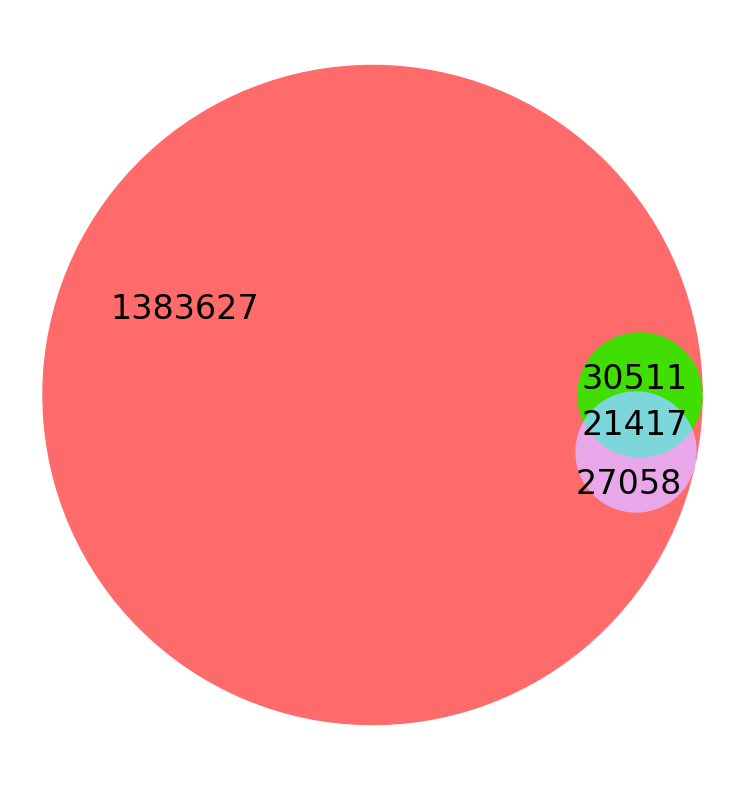

In [49]:
plot_venn_diagram(result_df, score_threshold=0.8)